In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf, validate_on
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms
import numpy as np
LEARNING_RATE = 0.0001

0.90 - For proving that using pre-trained model works better

In [2]:
# train_ds, val_ds, label_names = dataset_tf("./dataset/sbcm_hive_1_train_copy", 0.30, 16)
train_ds, val_ds, label_names = dataset_tf("./dataset/pitched", 0.30, 16)

Found 490 files belonging to 2 classes.
Using 343 files for training.
Using 147 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (16, 4000)
Example label shape: (16,)


2024-03-26 00:24:49.993679: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-26 00:24:49.993700: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-26 00:24:49.993707: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-26 00:24:49.993738: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-26 00:24:49.993764: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [3]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

513 44100
513 44100


# Train raw models

## Raw - MFCCs

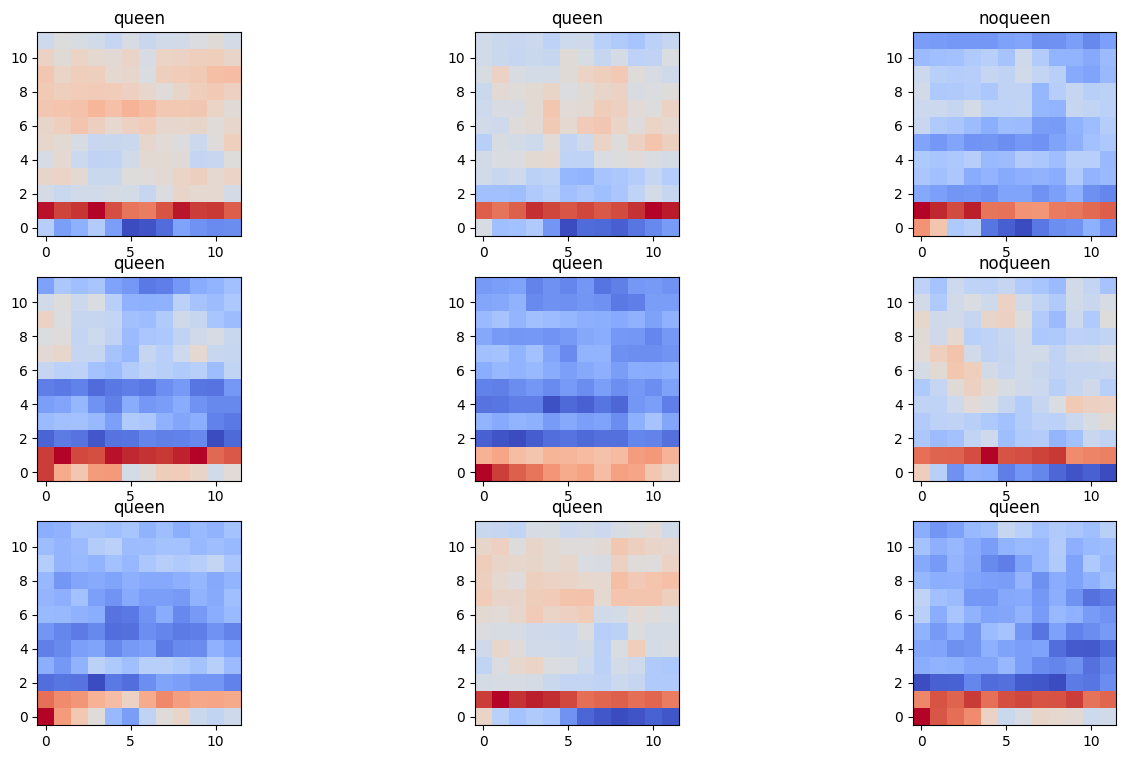

In [4]:
for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break

plot_mfccs(example_mfccs, example_mfccs_labels, label_names)

In [5]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))

for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break
input_shape = example_mfccs.shape[1:]
input_shape

TensorShape([12, 12, 1])

In [6]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [MFCCs] Sequential Model

2024-03-26 00:24:51.464525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20
 1/22 [>.............................] - ETA: 9s - loss: 0.7522 - accuracy: 0.3750

2024-03-26 00:24:52.016943: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


22/22 [==============================] - 1s 29ms/step - loss: 0.6876 - accuracy: 0.5685 - val_loss: 0.6407 - val_accuracy: 0.6531
Epoch 2/20
22/22 [==============================] - 0s 11ms/step - loss: 0.5731 - accuracy: 0.7230 - val_loss: 0.6133 - val_accuracy: 0.6735
Epoch 3/20
22/22 [==============================] - 0s 11ms/step - loss: 0.4936 - accuracy: 0.7872 - val_loss: 0.5877 - val_accuracy: 0.6735
Epoch 4/20
22/22 [==============================] - 0s 11ms/step - loss: 0.4278 - accuracy: 0.8251 - val_loss: 0.5493 - val_accuracy: 0.7415
Epoch 5/20
22/22 [==============================] - 0s 11ms/step - loss: 0.3481 - accuracy: 0.8892 - val_loss: 0.5379 - val_accuracy: 0.7483
Epoch 6/20
22/22 [==============================] - 0s 11ms/step - loss: 0.3204 - accuracy: 0.8805 - val_loss: 0.6298 - val_accuracy: 0.7211
Epoch 7/20
22/22 [==============================] - 0s 11ms/step - loss: 0.2719 - accuracy: 0.8921 - val_loss: 0.5509 - val_accuracy: 0.7755


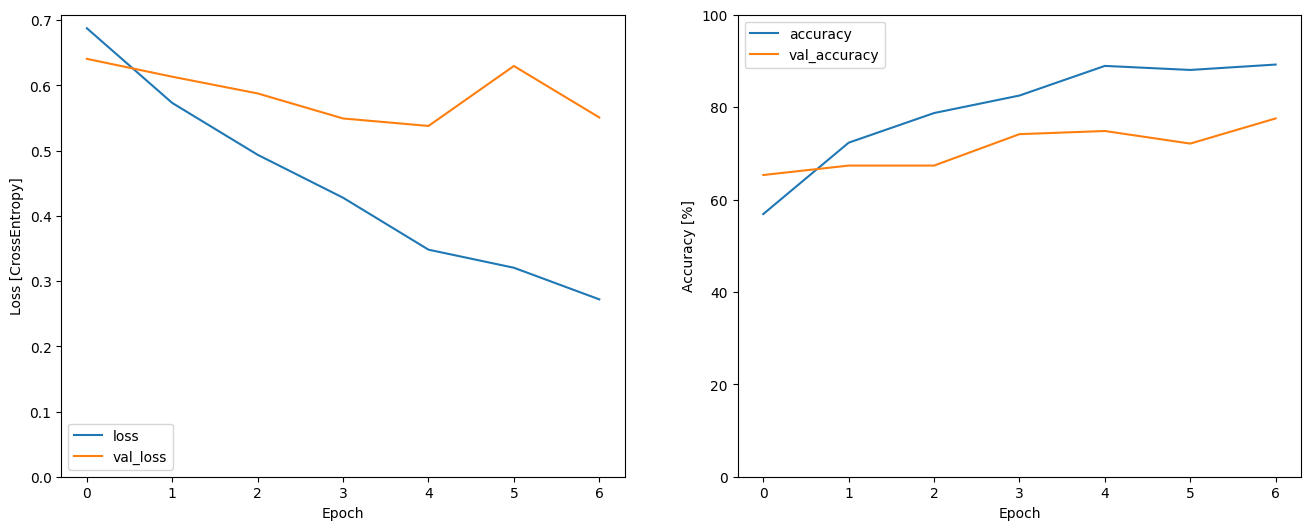

In [7]:
model_mfcc_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_mfcc_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_mfcc_seq = model_mfcc_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_seq)

### [Reinf:Raw] [MFCCs] Convolutional Model (mini)

Epoch 1/20
22/22 [==============================] - 1s 14ms/step - loss: 0.7478 - accuracy: 0.4723 - val_loss: 0.7125 - val_accuracy: 0.4150
Epoch 2/20
22/22 [==============================] - 0s 6ms/step - loss: 0.7089 - accuracy: 0.4665 - val_loss: 0.7014 - val_accuracy: 0.5102
Epoch 3/20
22/22 [==============================] - 0s 6ms/step - loss: 0.6974 - accuracy: 0.5248 - val_loss: 0.6944 - val_accuracy: 0.5102
Epoch 4/20
22/22 [==============================] - 0s 6ms/step - loss: 0.6868 - accuracy: 0.5335 - val_loss: 0.6864 - val_accuracy: 0.5034
Epoch 5/20
22/22 [==============================] - 0s 6ms/step - loss: 0.6760 - accuracy: 0.5743 - val_loss: 0.6804 - val_accuracy: 0.4898
Epoch 6/20
22/22 [==============================] - 0s 6ms/step - loss: 0.6675 - accuracy: 0.6035 - val_loss: 0.6751 - val_accuracy: 0.5510
Epoch 7/20
22/22 [==============================] - 0s 6ms/step - loss: 0.6600 - accuracy: 0.6093 - val_loss: 0.6704 - val_accuracy: 0.5442
Epoch 8/20
22/22 [=

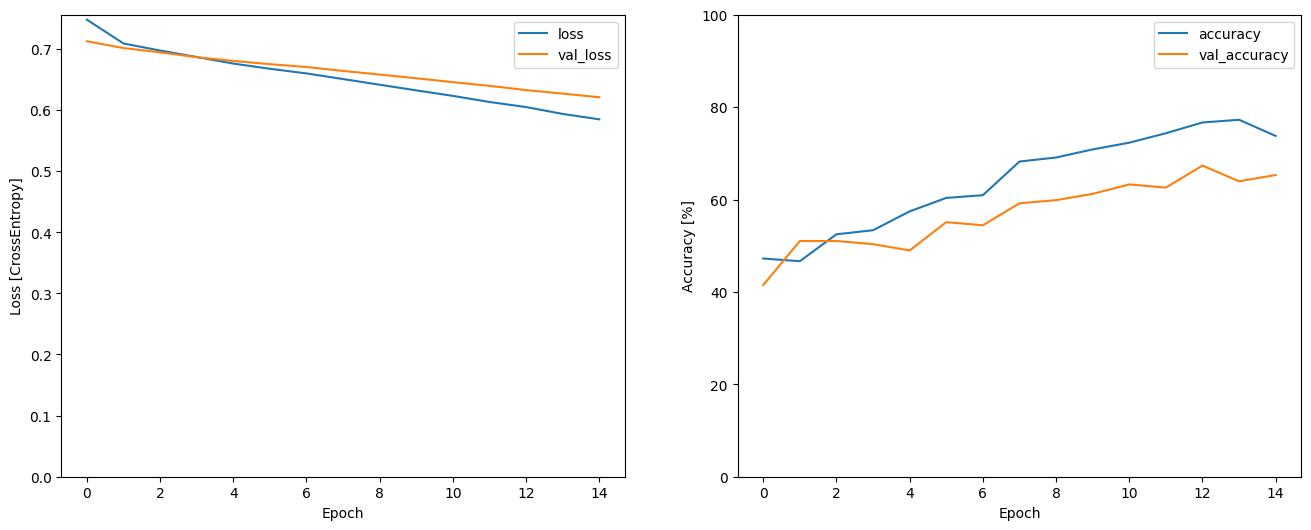

In [8]:
model_mfcc_conv = get_conv_model_mini(input_shape, len(label_names))
model_mfcc_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_mfcc_conv = model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_conv)

## Raw - Spectrograms

(118, 129, 1)


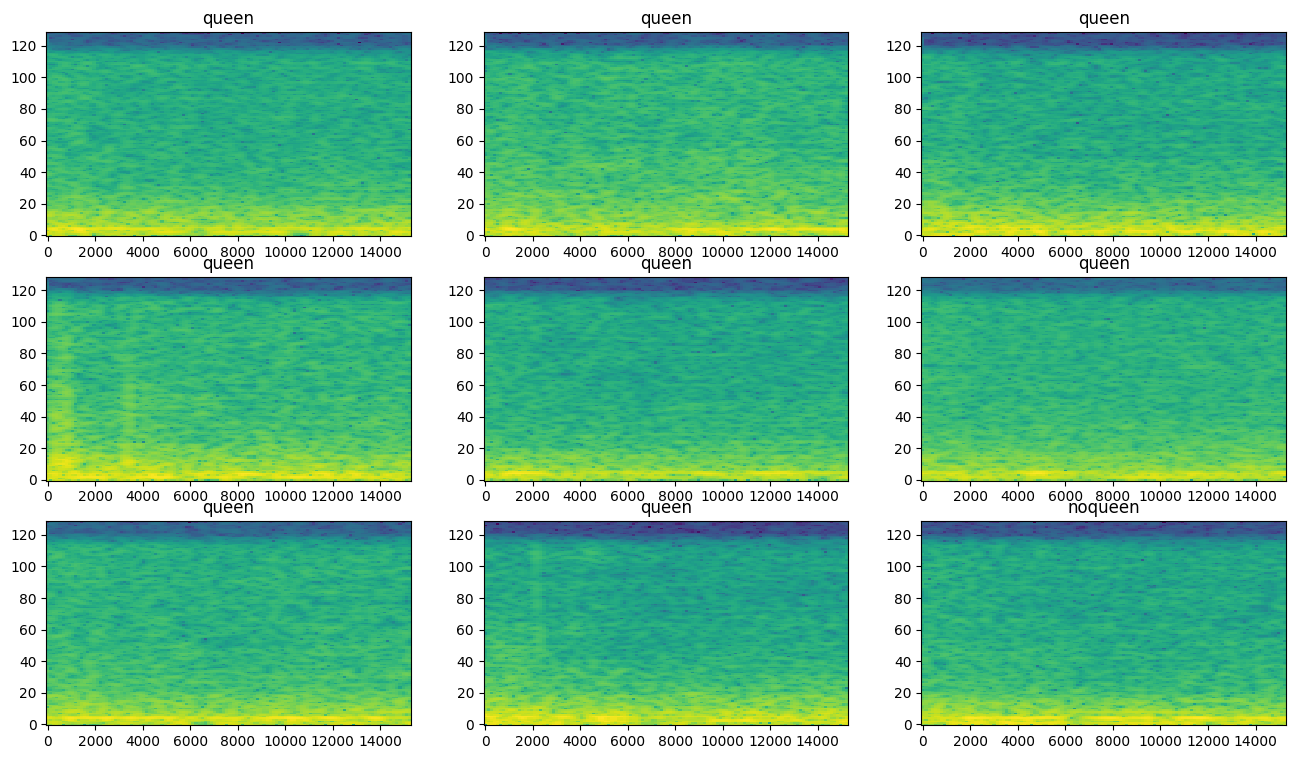

In [9]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [10]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Reinf:Raw] [Spec] Sequential model

Epoch 1/20
22/22 [==============================] - 1s 22ms/step - loss: 0.7079 - accuracy: 0.4723 - val_loss: 0.6874 - val_accuracy: 0.5238
Epoch 2/20
22/22 [==============================] - 0s 11ms/step - loss: 0.6751 - accuracy: 0.5918 - val_loss: 0.6828 - val_accuracy: 0.5374
Epoch 3/20
22/22 [==============================] - 0s 11ms/step - loss: 0.6715 - accuracy: 0.5539 - val_loss: 0.6794 - val_accuracy: 0.5170
Epoch 4/20
22/22 [==============================] - 0s 11ms/step - loss: 0.6484 - accuracy: 0.6327 - val_loss: 0.6830 - val_accuracy: 0.5238
Epoch 5/20
22/22 [==============================] - 0s 11ms/step - loss: 0.6420 - accuracy: 0.5889 - val_loss: 0.6669 - val_accuracy: 0.5578
Epoch 6/20
22/22 [==============================] - 0s 12ms/step - loss: 0.6046 - accuracy: 0.6939 - val_loss: 0.6809 - val_accuracy: 0.5306
Epoch 7/20
22/22 [==============================] - 0s 11ms/step - loss: 0.5854 - accuracy: 0.6793 - val_loss: 0.6421 - val_accuracy: 0.6190
Epoch 8/20
22

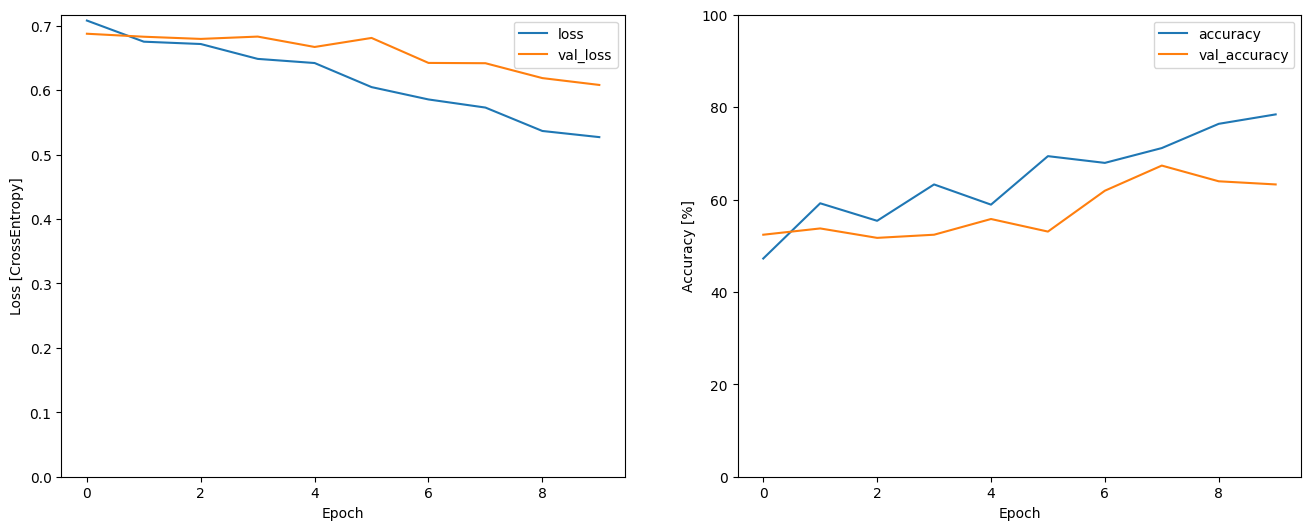

In [11]:
model_spec_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_spec_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_spec_seq = model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_seq)

### [Reinf:Raw] [Spec] Convolutional model

Epoch 1/20
22/22 [==============================] - 1s 19ms/step - loss: 0.7521 - accuracy: 0.4694 - val_loss: 0.7132 - val_accuracy: 0.4830
Epoch 2/20
22/22 [==============================] - 0s 9ms/step - loss: 0.6852 - accuracy: 0.5394 - val_loss: 0.6833 - val_accuracy: 0.5170
Epoch 3/20
22/22 [==============================] - 0s 8ms/step - loss: 0.6810 - accuracy: 0.5685 - val_loss: 0.6813 - val_accuracy: 0.6395
Epoch 4/20
22/22 [==============================] - 0s 9ms/step - loss: 0.6769 - accuracy: 0.6239 - val_loss: 0.6842 - val_accuracy: 0.5306
Epoch 5/20
22/22 [==============================] - 0s 8ms/step - loss: 0.6730 - accuracy: 0.5656 - val_loss: 0.6807 - val_accuracy: 0.5578
Epoch 6/20
22/22 [==============================] - 0s 8ms/step - loss: 0.6667 - accuracy: 0.6531 - val_loss: 0.6733 - val_accuracy: 0.6327
Epoch 7/20
22/22 [==============================] - 0s 8ms/step - loss: 0.6671 - accuracy: 0.6122 - val_loss: 0.6739 - val_accuracy: 0.6122
Epoch 8/20
22/22 [=

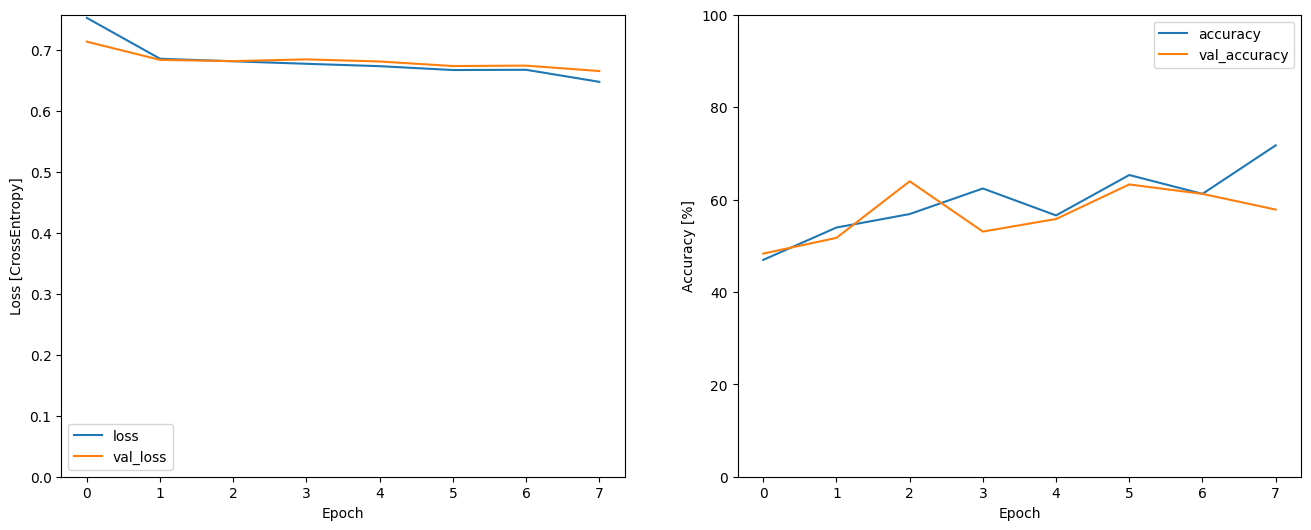

In [12]:
model_spec_conv = get_conv_model(input_shape, len(label_names))
model_spec_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_spec_conv = model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_conv)

# Pre-trained models

In [13]:
trained_model_mfcc_seq = tf.keras.models.load_model("models/mfcc_seq.h5")
trained_model_mfcc_conv = tf.keras.models.load_model("models/mfcc_conv_mini.h5")
trained_model_spec_seq = tf.keras.models.load_model("models/spec_seq.h5")
trained_model_spec_conv = tf.keras.models.load_model("models/spec_conv.h5")

In [14]:
results = trained_model_mfcc_seq.evaluate(val_mfccs_ds)
print(f"MFCC Seq: {results}")
results = trained_model_mfcc_conv.evaluate(val_mfccs_ds)
print(f"MFCC Conv: {results}")
results = trained_model_spec_seq.evaluate(val_spectrogram_ds)
print(f"Spec Seq: {results}")
results = trained_model_spec_conv.evaluate(val_spectrogram_ds)
print(f"Spec Conv: {results}")

10/10 [==============================] - 0s 10ms/step - loss: 1.0971 - accuracy: 0.5238
MFCC Seq: [1.0971055030822754, 0.523809552192688]
10/10 [==============================] - 0s 7ms/step - loss: 0.9841 - accuracy: 0.5238
MFCC Conv: [0.9841259717941284, 0.523809552192688]
10/10 [==============================] - 0s 10ms/step - loss: 3.5200 - accuracy: 0.5170
Spec Seq: [3.520028591156006, 0.5170068144798279]
10/10 [==============================] - 0s 8ms/step - loss: 8.8620 - accuracy: 0.5170
Spec Conv: [8.861955642700195, 0.5170068144798279]


### [Reinf] [MFCCs] Sequential model

Epoch 1/20
22/22 [==============================] - 1s 15ms/step - loss: 0.9907 - accuracy: 0.5481 - val_loss: 0.8241 - val_accuracy: 0.5578
Epoch 2/20
22/22 [==============================] - 0s 11ms/step - loss: 0.7095 - accuracy: 0.6210 - val_loss: 0.6996 - val_accuracy: 0.5986
Epoch 3/20
22/22 [==============================] - 0s 12ms/step - loss: 0.5872 - accuracy: 0.7026 - val_loss: 0.6539 - val_accuracy: 0.6531
Epoch 4/20
22/22 [==============================] - 0s 11ms/step - loss: 0.5584 - accuracy: 0.7114 - val_loss: 0.6373 - val_accuracy: 0.6735
Epoch 5/20
22/22 [==============================] - 0s 13ms/step - loss: 0.5149 - accuracy: 0.7464 - val_loss: 0.6520 - val_accuracy: 0.6735
Epoch 6/20
22/22 [==============================] - 0s 12ms/step - loss: 0.4863 - accuracy: 0.7668 - val_loss: 0.6201 - val_accuracy: 0.7143
Epoch 7/20
22/22 [==============================] - 0s 11ms/step - loss: 0.4592 - accuracy: 0.7901 - val_loss: 0.5925 - val_accuracy: 0.7075
Epoch 8/20
22

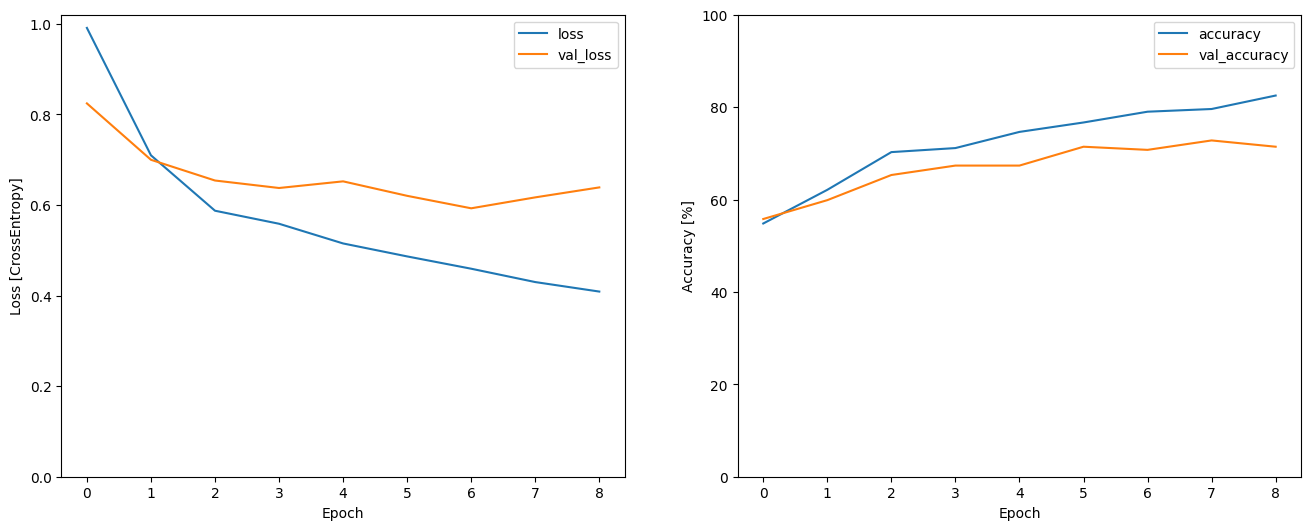

In [15]:
trained_history_mfcc_seq = trained_model_mfcc_seq.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_mfcc_seq)

### [Reinf] [MFCCs] Convolutional model (mini)

Epoch 1/20
22/22 [==============================] - 0s 9ms/step - loss: 0.7364 - accuracy: 0.5918 - val_loss: 0.7024 - val_accuracy: 0.5782
Epoch 2/20
22/22 [==============================] - 0s 7ms/step - loss: 0.6465 - accuracy: 0.6268 - val_loss: 0.6478 - val_accuracy: 0.6463
Epoch 3/20
22/22 [==============================] - 0s 6ms/step - loss: 0.6085 - accuracy: 0.6851 - val_loss: 0.6248 - val_accuracy: 0.6395
Epoch 4/20
22/22 [==============================] - 0s 6ms/step - loss: 0.5834 - accuracy: 0.7318 - val_loss: 0.6138 - val_accuracy: 0.6259
Epoch 5/20
22/22 [==============================] - 0s 6ms/step - loss: 0.5629 - accuracy: 0.7347 - val_loss: 0.6037 - val_accuracy: 0.6531
Epoch 6/20
22/22 [==============================] - 0s 6ms/step - loss: 0.5556 - accuracy: 0.7289 - val_loss: 0.5914 - val_accuracy: 0.6599
Epoch 7/20
22/22 [==============================] - 0s 6ms/step - loss: 0.5358 - accuracy: 0.7638 - val_loss: 0.5821 - val_accuracy: 0.6803
Epoch 8/20
22/22 [==

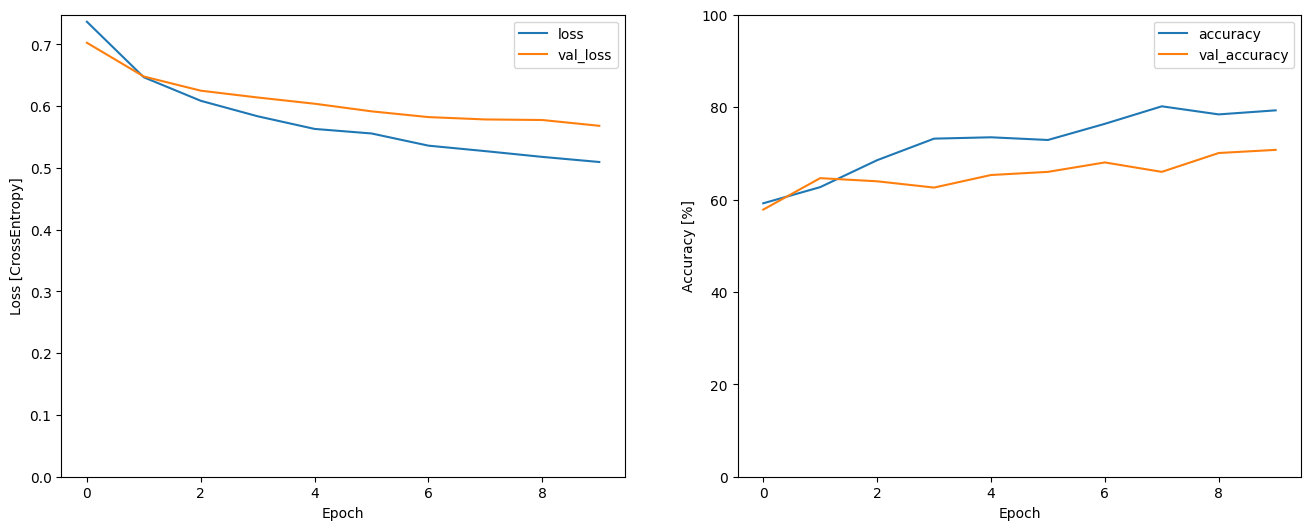

In [16]:
trained_history_mfcc_conv = trained_model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_mfcc_conv)

### [Reinf] [Spec] Sequential model

Epoch 1/20
22/22 [==============================] - 1s 16ms/step - loss: 1.5167 - accuracy: 0.5102 - val_loss: 1.9356 - val_accuracy: 0.4830
Epoch 2/20
22/22 [==============================] - 0s 12ms/step - loss: 1.1573 - accuracy: 0.4898 - val_loss: 1.1460 - val_accuracy: 0.4898
Epoch 3/20
22/22 [==============================] - 0s 12ms/step - loss: 0.7738 - accuracy: 0.5743 - val_loss: 0.8943 - val_accuracy: 0.5102
Epoch 4/20
22/22 [==============================] - 0s 13ms/step - loss: 0.7337 - accuracy: 0.5598 - val_loss: 0.9004 - val_accuracy: 0.5170
Epoch 5/20
22/22 [==============================] - 0s 12ms/step - loss: 0.6725 - accuracy: 0.5714 - val_loss: 0.7471 - val_accuracy: 0.5238
Epoch 6/20
22/22 [==============================] - 0s 12ms/step - loss: 0.6197 - accuracy: 0.6414 - val_loss: 0.7403 - val_accuracy: 0.5510
Epoch 7/20
22/22 [==============================] - 0s 12ms/step - loss: 0.5870 - accuracy: 0.6822 - val_loss: 0.7209 - val_accuracy: 0.5578
Epoch 8/20
22

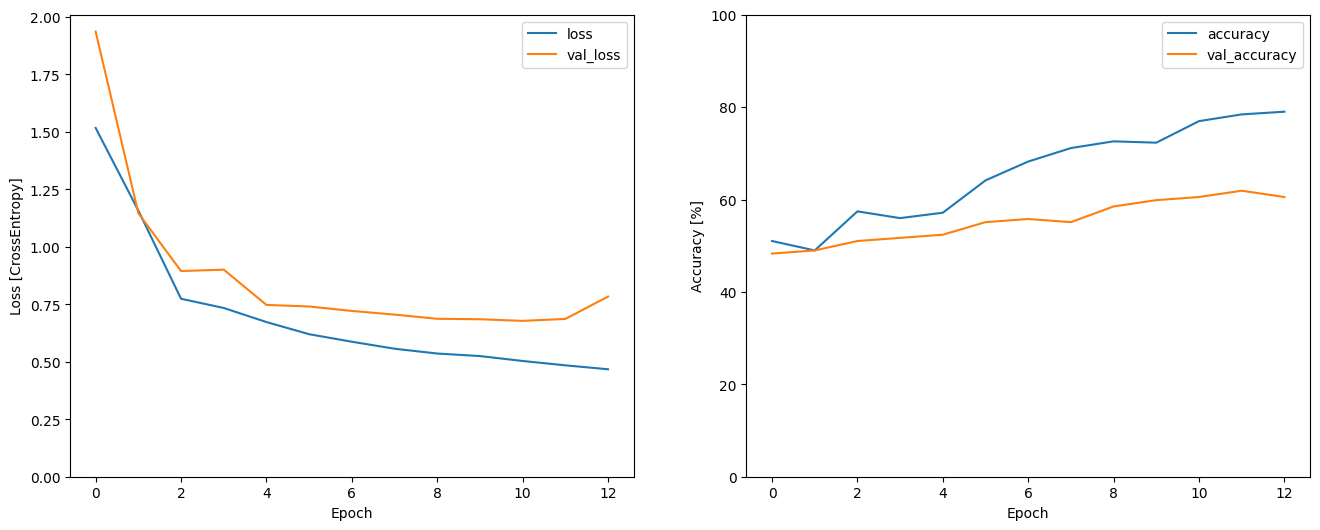

In [17]:
trained_history_spec_seq = trained_model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_spec_seq)

### [Reinf] [Spec] Convolutional model

Epoch 1/20
22/22 [==============================] - 0s 12ms/step - loss: 2.9471 - accuracy: 0.4286 - val_loss: 1.4422 - val_accuracy: 0.4626
Epoch 2/20
22/22 [==============================] - 0s 11ms/step - loss: 1.5809 - accuracy: 0.4344 - val_loss: 1.3565 - val_accuracy: 0.4490
Epoch 3/20
22/22 [==============================] - 0s 10ms/step - loss: 1.3029 - accuracy: 0.4606 - val_loss: 1.2778 - val_accuracy: 0.4490
Epoch 4/20
22/22 [==============================] - 0s 11ms/step - loss: 1.2376 - accuracy: 0.4723 - val_loss: 1.2214 - val_accuracy: 0.4626
Epoch 5/20
22/22 [==============================] - 0s 10ms/step - loss: 1.1981 - accuracy: 0.4490 - val_loss: 1.1874 - val_accuracy: 0.4694
Epoch 6/20
22/22 [==============================] - 0s 10ms/step - loss: 1.1611 - accuracy: 0.4665 - val_loss: 1.1751 - val_accuracy: 0.4626


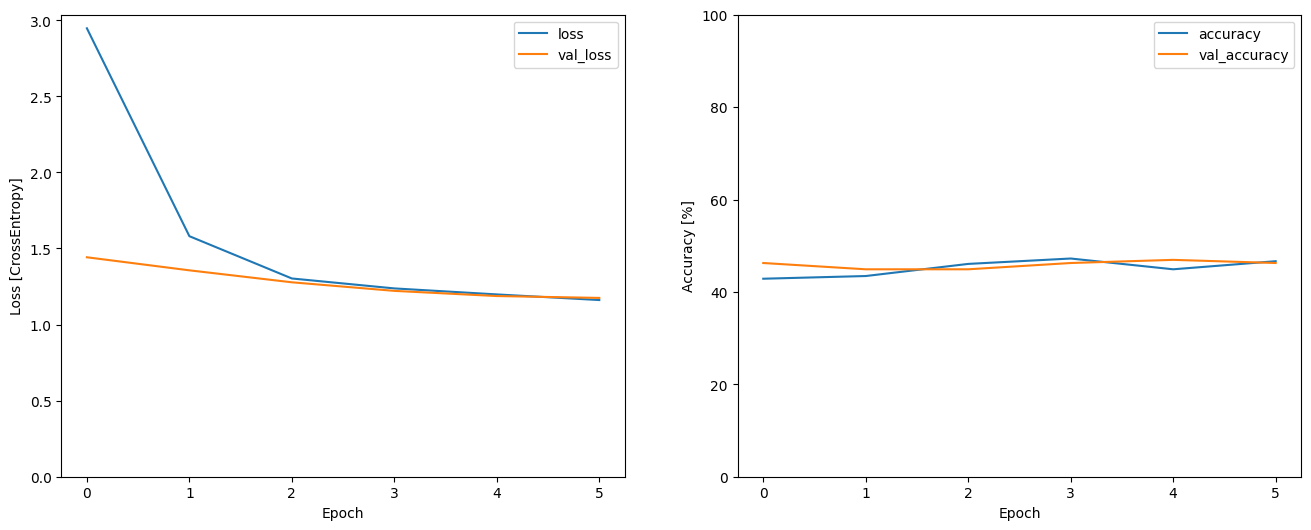

In [18]:
trained_history_spec_conv = trained_model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(trained_history_spec_conv)

# Save models

In [19]:
trained_model_mfcc_seq.save('models/renf_mfcc_seq.h5')
trained_model_mfcc_conv.save('models/renf_mfcc_conv.h5')
trained_model_spec_seq.save('models/renf_spec_seq.h5')
trained_model_spec_conv.save('models/renf_spec_conv.h5')

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Summary

In [20]:
def history_to_summary(prefix: str, history):
    print(f"{prefix}:    Loss: {history.history['loss'][-1]:.2f}, Acc: {history.history['accuracy'][-1]:.2f}, VLoss: {history.history['val_loss'][-1]:.2f}, VAcc: {history.history['val_accuracy'][-1]:.2f}" )

print("=== RAW ===")
history_to_summary("MFCCs + Seq       ", history_mfcc_seq)
history_to_summary("MFCCs + Conv      ", history_mfcc_conv)
history_to_summary("Spectrogram + Seq ", history_spec_seq)
history_to_summary("Spectrogram + Conv", history_spec_conv)
print("")
print("=== TRAINED ===")
history_to_summary("Tr. MFCCs + Seq       ", trained_history_mfcc_seq)
history_to_summary("Tr. MFCCs + Conv      ", trained_history_mfcc_conv)
history_to_summary("Tr. Spectrogram + Seq ", trained_history_spec_seq)
history_to_summary("Tr. Spectrogram + Conv", trained_history_spec_conv)


=== RAW ===
MFCCs + Seq       :    Loss: 0.27, Acc: 0.89, VLoss: 0.55, VAcc: 0.78
MFCCs + Conv      :    Loss: 0.58, Acc: 0.74, VLoss: 0.62, VAcc: 0.65
Spectrogram + Seq :    Loss: 0.53, Acc: 0.78, VLoss: 0.61, VAcc: 0.63
Spectrogram + Conv:    Loss: 0.65, Acc: 0.72, VLoss: 0.67, VAcc: 0.58

=== TRAINED ===
Tr. MFCCs + Seq       :    Loss: 0.41, Acc: 0.83, VLoss: 0.64, VAcc: 0.71
Tr. MFCCs + Conv      :    Loss: 0.51, Acc: 0.79, VLoss: 0.57, VAcc: 0.71
Tr. Spectrogram + Seq :    Loss: 0.47, Acc: 0.79, VLoss: 0.78, VAcc: 0.61
Tr. Spectrogram + Conv:    Loss: 1.16, Acc: 0.47, VLoss: 1.18, VAcc: 0.46
